# Test implementation of PhenomD fit

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from phenom.utils.utils import UsefulPowers
import phenom, pwca

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from Welsh Puck (aka pwca).
(pwca.core)>> Catalog of calibration runs stored to "pwca.pwca_catalog"
(pwca.core)>> Metadata dictionary for calibration runs stored to "pwca.metadata_dict"


## Find and load simulation data

In [2]:
# Find a simulation 
A = scsearch(keyword='hrq',nonspinning=True,verbose=True,q=2,unique=True)

(scsearch)>> Found keyword (=hrq) keyword.
(scsearch)>> Found nonspinning (=True) keyword.
(scsearch)>> Found q (=2) keyword.
(scsearch)>> Found unique (=True) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
## Found 1 unique simulations:
[0001][bradwr] HRq-series: ns-q2.00	(D9_q2.0_a0.0_m160)



In [3]:
# Load waveform
y = gwylm(A[0],lm=(2,2),verbose=True,pad=500,dt=0.5,clean=True,load_dynamics=False)

(gwylm)>> Found clean (=True) keyword.
(gwylm)>> Found dt (=0.5) keyword.
(gwylm)>> Found enforce_m_relative_sign_convention (=True) keyword.
(gwylm)>> Found lm (=(2, 2)) keyword.
(gwylm)>> Found pad (=500) keyword.
(gwylm)>> Found scentry_obj (=<nrutils.core.nrsc.scentry instance at 0x117226be0>) keyword.
(gwylm)>> Found verbose (=True) keyword.
(__init__)>> Using default M_RELATIVE_SIGN_CONVENTION of 1
(gwylm)>> The (extraction_parameter,level) is (75.0,None), which differs from the config values of (75,0). You have either manually input the non-config values, or the handler has set them by looking at the contents of the simulation directory. 
(__make_lmlist__)>> The following spherical multipoles will be loaded:[(2, 2)]
(load)>> Using the default extraction_parameter of 75
(load)>> Using the default level of 75
(load)>> Loading: mp_WeylScal4::Psi4i_l2_m2_r75.00.asc
(load)>> Padding wfarr. The old data length was 2198, and the new one is 2698
(pad_wfarr)>> The shape was (2198, 3). No

## Generate Full PhenomD Waveform

In [4]:

# Pull information from gwylm object
m1, m2, chi1, chi2, chip = y.m1, y.m2, y.X1[-1], y.X2[-1], 0

# Convert to fiducial physical units
M = 100.0
M1,M2 = [ k*M for k in (m1,m2) ]
D_Mpc = 100.0
D_meters = mpc2meters(D_Mpc)
f_min = physf( min(y.f[y.f>0]), M )
f_max = 0*physf( max(y.f[y.f>0]), M )
df_hz = physf( y.f[1]-y.f[0], M )

#
bar = phenom.PhenomD(m1=M1, m2=M2, chi1z=chi1, chi2z=chi2, f_min=f_min, f_max=f_max, distance=D_meters, delta_f=df_hz)
bar.IMRPhenomDGenerateFD()

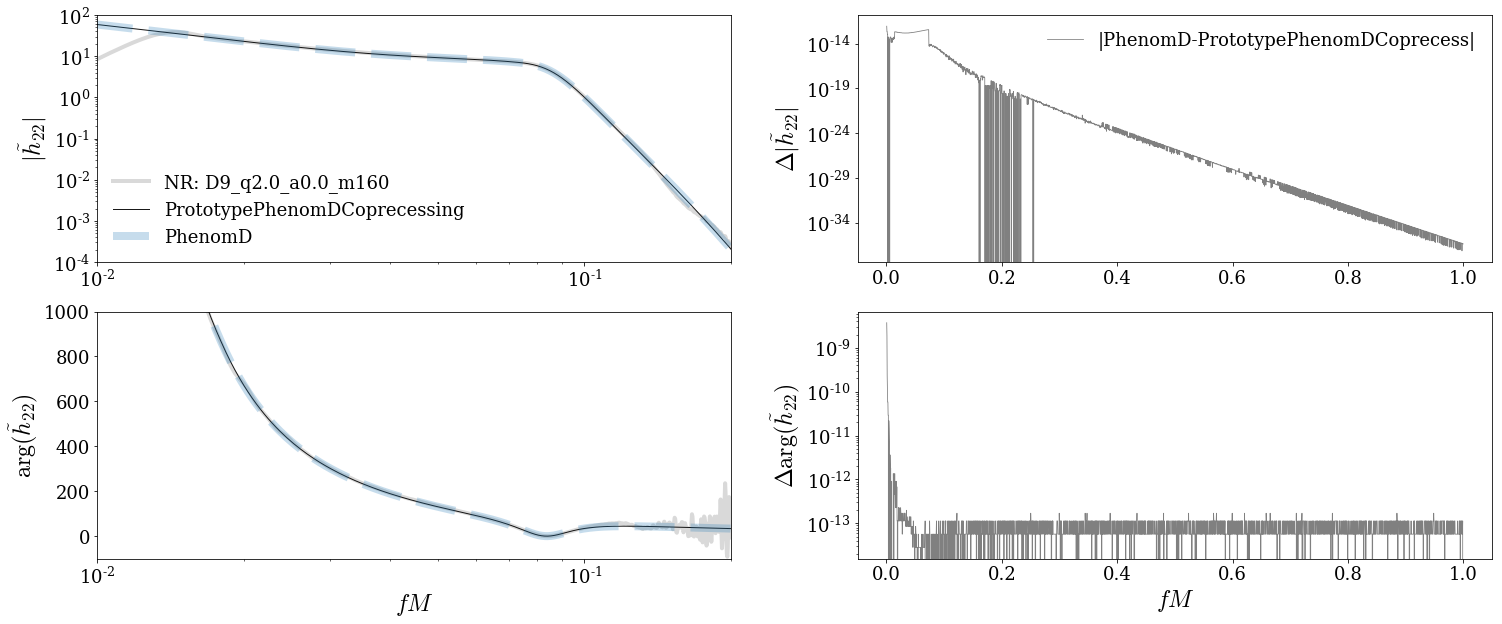

In [5]:

fig = figure( figsize=2.5*figaspect(0.8/2) )
lw = 1

subplot(2,2,1)
# ---

#
f = y.f[y.f>0]

#
template_amp, template_dphi, template_phi = pwca.template_amp_phase(m1, m2, chi1, chi2, chip)
foo_amp = template_amp(f)
foo_dphi = -template_dphi(f)

#
bar_amp  = array( [bar.IMRPhenomDAmplitude(k, bar.model_pars, UsefulPowers(k)) for k in f] )
bar_dphi = array( [bar.IMRPhenomDPhaseDerivFrequencyPoint(k,bar.p['eta'], bar.model_pars) for k in f] )

#
plot( y.f[y.f>0], y[2,2]['strain'].fd_amp[y.f>0], label='NR: %s'%y.simname,lw=4,color='0.85' )
plot( f, foo_amp, label='PrototypePhenomDCoprecessing',lw=1,color='k',alpha=0.9 )
plot( f, bar_amp, label='PhenomD',ls='--',lw=8,alpha=0.25 )
xscale('log')
yscale('log')

ylim(1e-4,1e2)
xlim( 1e-2,0.2 )

ylabel(r'$|\tilde{h}_{22}|$')
legend()

subplot(2,2,3)
# ---

fring = pwca.d.fring(y.eta,chi1,chi2,y.xf) 
shift = y[2,2]['psi4'].fd_dphi[find(y.f>fring)[0]]
plot( y.f[y.f>0], y[2,2]['strain'].fd_dphi[y.f>0]-shift, label='',lw=4,color='0.85' )

plot( f, -foo_dphi-min(-foo_dphi), label='',lw=1,color='k',alpha=0.9 )
plot( f, -bar_dphi-min(-bar_dphi), label='',ls='--',lw=8,alpha=0.25 )

xscale('log')
xlim( 1e-2,0.2 )
ylim(-1e2,1e3)

ylabel(r'$\arg(\tilde{h}_{22})$')
xlabel('$fM$')

subplot(2,2,2)
# ---

plot( f, abs(foo_amp-bar_amp), color='0.5',label='|PhenomD-PrototypePhenomDCoprecess|' )
ylabel(r'$\Delta|\tilde{h}_{22}|$')
yscale('log')
legend()

subplot(2,2,4)
# ---

plot( f, abs(-foo_dphi-min(-foo_dphi)-(-bar_dphi-min(-bar_dphi))), color='0.5' )
ylabel(r'$\Delta\arg(\tilde{h}_{22})$')
yscale('log')
xlabel('$fM$');

## Verify that template phase function is consistent with template_dphi

In [6]:
foo_phi = template_phi(f)
test_dphi = spline_diff(f,foo_phi)

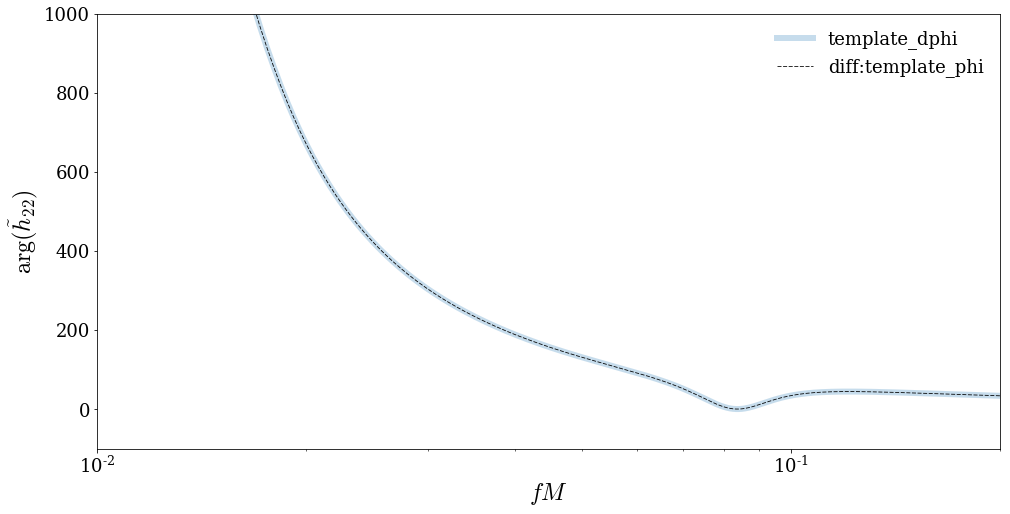

In [7]:

figure( figsize=2*figaspect(0.618*0.8) )

plot( f, -(foo_dphi-max(foo_dphi)), lw=6, alpha=0.25, label='template_dphi' )
plot( f, -(test_dphi-max(test_dphi)),ls='--',color='k',label='diff:template_phi' )

xscale('log')
xlim( 1e-2,0.2 )
ylim(-1e2,1e3)
ylabel(r'$\arg(\tilde{h}_{22})$')
legend()
xlabel('$fM$');